# Kanno et al. (2006)

In which the GMPE of Kanno et al. (2006) is implemented. First coefficient tables are reprocessed for cut & paste in to the .py source code. Then, key figures in the original paper are reproduced for validation. Finally, test vectors are produced for automatic code verification using unittest.

In [1]:
%matplotlib inline
%load_ext autoreload

## Processing of coefficients

In [2]:
import os
import glob
import warnings
import importlib
import pandas as pd
import numpy as np
import toolbox as tb
import matplotlib.pyplot as plt
from scipy.constants import g
from matplotlib.offsetbox import AnchoredText
from IPython.display import display
from openquake.hazardlib import imt

In [3]:
tables_file = 'Tables/Tables.xlsx'
tables_dir = os.path.split(tables_file)[0]
table_numbers = range(3,7)

coeffs_dfs = [pd.read_excel(tables_file, sheetname='Table%d' % num, skiprows=1) 
               for num in table_numbers]
coeffs_txts = [os.path.join(tables_dir, 'Table%d.txt' % num) 
               for num in table_numbers]

for coeffs_df, coeffs_txt in zip(coeffs_dfs, coeffs_txts):
    with open(coeffs_txt, 'w') as f:
        f.write(coeffs_df.to_string(index=False))

coeffs_df = pd.merge(coeffs_dfs[0], coeffs_dfs[1], on='IMT', suffixes=['1','2'], copy=True)
coeffs_df = pd.merge(coeffs_df, coeffs_dfs[2], on='IMT')
coeffs_df = pd.merge(coeffs_df, coeffs_dfs[3], on='IMT')
coeffs_df.set_index(keys='IMT', inplace=True)

In [4]:
# test out some ideas about inheritance
class A(object):
    CONST = 'A'
    def foo(self):
        return self.CONST

class B(A):
    CONST = 'B'

class Aprime(A):
    prime = 'prime'
    def foo(self):
        return super(Aprime, self).foo() + self.prime

class Bprime(Aprime, B):
    pass

myA = A()
print myA.foo()
myB = B()
print myB.foo()
myAprime = Aprime()
print myAprime.foo()
myBprime = Bprime()
print myBprime.foo()

A
B
Aprime
Bprime


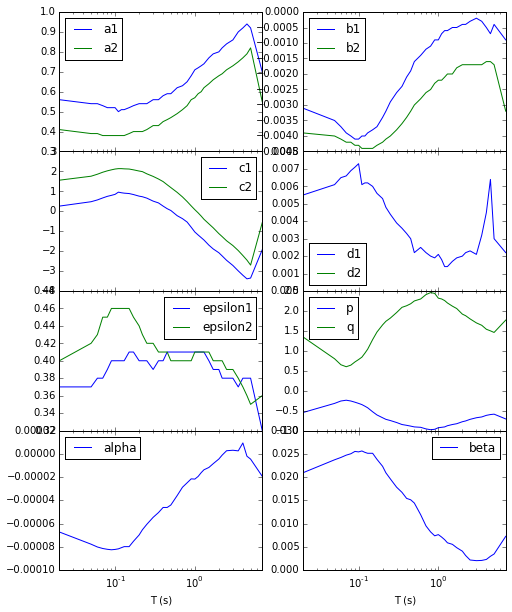

In [5]:
sa_df = coeffs_df.copy()
sa_df['T (s)'] = sa_df.index.values
# modify so that they will plot
sa_df.loc['pga','T (s)'] = 0.02
sa_df.loc['pgv','T (s)'] = 7
fig, axes = plt.subplots(4, 2, figsize=(8,10), sharex=True)
fig.subplots_adjust(hspace=0)
sa_df.plot(x='T (s)', y=['a1', 'a2'], ax=axes[0,0], logx=True)
sa_df.plot(x='T (s)', y=['b1', 'b2'], ax=axes[0,1], logx=True)
sa_df.plot(x='T (s)', y=['c1', 'c2'], ax=axes[1,0], logx=True)
sa_df.plot(x='T (s)', y=['d1', 'd2'], ax=axes[1,1], logx=True)
sa_df.plot(x='T (s)', y=['epsilon1', 'epsilon2'], ax=axes[2,0], logx=True)
sa_df.plot(x='T (s)', y=['p', 'q'], ax=axes[2,1], logx=True)
sa_df.plot(x='T (s)', y=['alpha'], ax=axes[3,0], logx=True)
sa_df.plot(x='T (s)', y=['beta'], ax=axes[3,1], logx=True)
plt.savefig('Figures_3_and_8(c)_computed.pdf', dpi=300, bbox_inches='tight')
plt.savefig('Figures_3_and_8(c)_computed.png', dpi=300, bbox_inches='tight')

## Testing of GMPE

In [6]:
%autoreload 2
import gmpe_tools as gt

from openquake.hazardlib import gsim

%autoreload 2
from openquake.hazardlib.gsim.kanno_2006 \
    import (
        Kanno2006Shallow, 
        Kanno2006Deep, 
#        Kanno2006ShallowNortheastJapan, 
#        Kanno2006DeepNortheastJapan
    )

In [7]:
gmpe_group = 'KNMF06'
gmpes = [
    Kanno2006Shallow(),
    Kanno2006Deep(), 
#    Kanno2006ShallowNortheastJapan(),
#    Kanno2006DeepNortheastJapan(),
]
gmpe_class_names = [gmpe.__class__.__name__ for gmpe in gmpes]
gmpes_short = [
    'S',
    'D',
#    'S_NE',
#    'D_NE',
]
gmpes_long = [
    'Shallow',
    'Deep',
#    'Shallow northeast Japan',
#    'Deep northeast Japan',
]

In [8]:
for gmpe in gmpes:
    gt.print_gmpe_summary(gmpe)

Kanno2006Shallow
Supported tectonic region: Subduction Interface
Supported intensity measure types: PGA, SA, PGV
Supported component: Peak square root of sum of squares of horizontals
Supported standard deviations: Total
Required site parameters: vs30
Required rupture parameters: mag
Required distance parameters: rrup

Kanno2006Deep
Supported tectonic region: Subduction IntraSlab
Supported intensity measure types: PGA, SA, PGV
Supported component: Peak square root of sum of squares of horizontals
Supported standard deviations: Total
Required site parameters: vs30
Required rupture parameters: mag
Required distance parameters: rrup



In [9]:
# generate data for bedrock motion Figure 5
mags = [7.]
rakes = [0.]  # degrees
distances = [5., 20., 40., 80., 120., 200.]  # km
vs30s = 300.  # m/s FIXME this is an approximation of the zero-crossing
im_types = sorted(gmpes[0].COEFFS_BASE.sa_coeffs.keys())

df_means = [gt.compute_gmpe(gmpe, mags, rakes, distances, vs30s, im_types)[0]
            for gmpe in gmpes[:2]]

df_stddevs = [gt.compute_gmpe(gmpe, mags, rakes, distances, vs30s, im_types)[1]
            for gmpe in gmpes[:2]]

df_means = gt.df_massage(pd.concat(df_means, ignore_index=True))
df_stddevs = gt.df_massage(pd.concat(df_stddevs, ignore_index=True))

Digitized/M7_R120km_S.csv not available
Digitized/M7_R200km_S.csv not available
Digitized/M7_R5km_D.csv not available
Digitized/M7_R20km_D.csv not available


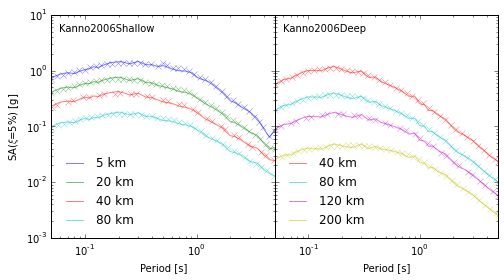

In [10]:
# produce Figure 5
digitized_template = 'Digitized/M%g_R%gkm_%s.csv'
empty = True

numeric_cols = np.array([tb.is_numeric(item) for item in df_means.columns])
extra_cols = df_means.columns[~numeric_cols]
T = [float(item) for item in df_means.columns[numeric_cols]]
# T = np.genfromtxt('Digitized/M7_T_S.csv')
gmpe_names = [name for name in gmpe_class_names 
              if (df_means['gmpe'] == name).any()]
distances = sorted(list(set(df_means['dist_rrup'])))

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,4))
fig.subplots_adjust(wspace=0)

for gmpe_name, ax in zip(gmpe_names, axes):
    
    ax.add_artist(AnchoredText(gmpe_name, loc=tb.LOC_CODE['upper left'], frameon=False))

    for dist in distances:
                
        df_trace = df_means[
            (df_means['gmpe'] == gmpe_name) &
            (df_means['dist_rrup'] == dist)]
        if df_trace.size == 0:
            print 'No data found for', trace_label
            continue
            
        series = df_trace.drop(extra_cols, axis=1).sort(axis=1).iloc[0,:]
            
        trace_label = '%g km' % dist
        h = ax.loglog(series.index, series.values,
                      label=trace_label, alpha=0.5)

        gmpe_short = [short for short, name in zip(gmpes_short, gmpe_class_names) 
                      if (gmpe_name == name)][0]
        digitized_file = digitized_template % (mags[0], dist, gmpe_short)
        if os.path.exists(digitized_file):
            data = np.genfromtxt(digitized_file, delimiter=',')
            data = data[data[:,0].argsort()]
            data[:, 1] = data[:, 1]/(100*g)
            ax.plot(data[:,0], data[:,1],
                    color=h[0].get_color(), marker='x', 
                    linestyle='none', alpha=0.5)
            
            df_trace.is_copy = False
            
            df_trace[T] = np.interp(T, data[:,0], data[:,1]).round(5)
            if empty:
                df_interp = df_trace
                empty = False
            else:
                df_interp = pd.concat((df_interp, df_trace), ignore_index=True)
        else:
            print '%s not available' % digitized_file
            ax.lines.remove(h[0])
                
    ax.set_xlabel('Period [s]')
    ax.set_xlim((min(T), max(T)))
    ax.legend(loc='lower left', frameon=False)
    
axes[0].set_ylim((1e-3, 10))
axes[0].set_ylabel('SA($\\xi$=%g%%) [g]' % im_types[0].damping)
plt.savefig('Figure_5_computed.pdf', dpi=300, bbox_inches='tight')
plt.savefig('Figure_5_computed.png', dpi=300, bbox_inches='tight')

In [11]:
df_interp

,gmpe,rup_mag,dist_rrup,site_vs30,damping,result_type,0.05,0.06,0.07,0.08,...,1.5,1.7,2.0,2.2,2.5,3.0,3.5,4.0,4.5,5.0
0,Kanno2006Shallow,7,5,300,5,MEAN,0.72157,0.81322,0.88616,0.95636,...,0.52641,0.41997,0.32820,0.28504,0.24031,0.18391,0.13024,0.09378,0.06806,0.08263
1,Kanno2006Shallow,7,20,300,5,MEAN,0.39552,0.44856,0.49186,0.53340,...,0.21075,0.17609,0.14032,0.12396,0.10591,0.08096,0.06451,0.05183,0.04176,0.03992
2,Kanno2006Shallow,7,40,300,5,MEAN,0.22578,0.25273,0.27675,0.29978,...,0.11448,0.09712,0.07947,0.06952,0.06039,0.04615,0.03842,0.03205,0.02805,0.02542
3,Kanno2006Shallow,7,80,300,5,MEAN,0.09538,0.10788,0.11734,0.12635,...,0.05805,0.04990,0.04055,0.03622,0.03146,0.02436,0.02067,0.01770,0.01514,0.01274
4,Kanno2006Deep,7,40,300,5,MEAN,0.57141,0.66785,0.75681,0.83667,...,0.15580,0.12663,0.09775,0.08446,0.07061,0.05407,0.04186,0.03339,0.02788,0.02331
5,Kanno2006Deep,7,80,300,5,MEAN,0.19652,0.22911,0.25766,0.28349,...,0.06531,0.05345,0.04171,0.03618,0.03024,0.02308,0.01798,0.01437,0.01196,0.01007
6,Kanno2006Deep,7,120,300,5,MEAN,0.08949,0.10372,0.11670,0.12817,...,0.03637,0.03048,0.02351,0.02079,0.01750,0.01328,0.01025,0.00836,0.00679,0.00580
7,Kanno2006Deep,7,200,300,5,MEAN,0.02575,0.02935,0.03252,0.03525,...,0.01534,0.01297,0.01036,0.00906,0.00762,0.00581,0.00452,0.00365,0.00304,0.00255


In [12]:
means_files = gt.write_test_data(df_interp, gmpe_group, gmpes_short, gmpe_class_names, 'FIG5')
stddev_files = gt.write_test_data(df_stddevs, gmpe_group, gmpes_short, gmpe_class_names, 'FIG5', float_format='%.5g')

In [13]:
# generate data for bedrock motion Figure 4
mags = [6.5, 7, 7.5, 8]
rakes = [0] # degrees
distances_list = [tb.logspace(1, 300, 6), tb.logspace(30, 300, 6)] # km
vs30s = [300.]  # m/s FIXME this is an approximation of the zero-crossing
im_types = [imt.PGA(), imt.PGV()]

df_means = [gt.compute_gmpe(gmpe, mags, rakes, distances, vs30s, im_types)[0]
            for gmpe, distances in zip(gmpes[:2], distances_list)]
df_stddevs = [gt.compute_gmpe(gmpe, mags, rakes, distances, vs30s, im_types)[1]
            for gmpe, distances in zip(gmpes[:2], distances_list)]

df_means = gt.df_massage(pd.concat(df_means, ignore_index=True))
df_stddevs = gt.df_massage(pd.concat(df_stddevs, ignore_index=True))

/home/nick/src/python/utils/gmpe_tools.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_ref.dropna(axis=1, inplace=True, how='all')
/usr/local/src/python/anaconda3/envs/py27/lib/python2.7/site-packages/pandas/core/frame.py:2915: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  inplace=inplace, kind=kind, na_position=na_position)


KeyError: 'the label [SA(0.05)] is not in the [columns]'

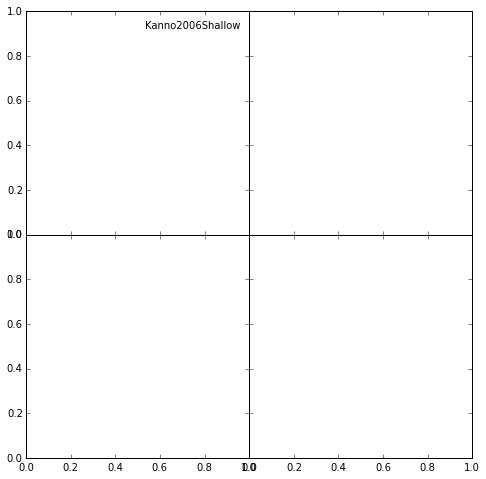

In [17]:
# produce Figure 4
digitized_template = 'Digitized/%s_M%g_%s.csv'
df_interp = df_means.copy()

gmpe_names = [name for name in gmpe_class_names 
              if (df_means['gmpe'] == name).any()]
mags = sorted(list(set(df_means['rup_mag'])))

fig, axes = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(8,8))
fig.subplots_adjust(hspace=0, wspace=0)

for im_type, row_axes in zip(im_types, axes):
    for gmpe_name, ax in zip(gmpe_names, row_axes):
        
        axis_label = gmpe_name
        ax.add_artist(AnchoredText(
                axis_label, loc=tb.LOC_CODE['upper right'], frameon=False))

        for mag in mags:

            trace_label = 'M=%g' % mag

            indices = ((df_means['gmpe'] == gmpe_name) &
                       (df_means['rup_mag'] == mag))
            if sum(indices) == 0:
                print 'No data found for', axis_label, trace_label
                continue

            x_column = 'dist_rrup'
            y_column = str(im_type)
                            
            x = df_means.loc[indices, x_column]
            y = df_means.loc[indices, y_column]
            h = ax.loglog(x, y, label=trace_label, alpha=0.5)

            gmpe_short = [short for short, name in zip(gmpes_short, gmpe_class_names) 
                          if (gmpe_name == name)][0]
            digitized_file = digitized_template % (im_type, mag, gmpe_short)
            if os.path.exists(digitized_file):
                data = np.genfromtxt(digitized_file, delimiter=',')
                data = data[data[:,0].argsort()]
                if str(im_type) != 'PGV':
                    data[:,1] = data[:,1]/(100*g)
                    
                ax.plot(data[:,0], data[:,1],
                        color=h[0].get_color(), marker='x', 
                        linestyle='none', alpha=0.5)

                df_interp.loc[indices, y_column] = np.interp(x, data[:,0], data[:,1]).round(5)
            else:
                print '%s not available' % digitized_file
        
        ax.set_xlim((min(x), max(x)))

for im_type, ax in zip(im_types, axes[:, 0]):
    if str(im_type) == 'PGA':
        ax.set_ylabel('PGA [g]')
    elif str(im_type) == 'PGV':
        ax.set_ylabel('PGV [cm/s]')
    else:
        ax.set_ylabel('SA($\\xi$=%g%%) [cm/s^2]' % im_types[0].damping)
        ax.set_ylim((1, 1e4))
        
for ax in axes[1, :]:
    ax.set_xlabel('Rupture Distance [km]')

axes[1, 0].legend(loc='lower left', frameon=False)
plt.savefig('Figure_4_computed.pdf', dpi=300, bbox_inches='tight')
plt.savefig('Figure_4_computed.png', dpi=300, bbox_inches='tight')

In [15]:
means_files = gt.write_test_data(df_interp, gmpe_group, gmpes_short, gmpe_class_names, 'FIG4')
stddev_files = gt.write_test_data(df_stddevs, gmpe_group, gmpes_short, gmpe_class_names, 'FIG4', float_format='%.5g')

['/home/nick/src/python/GEM/oq-hazardlib/openquake/hazardlib/tests/gsim/data/KNMF06/KNMF06_D_MEAN_FIG4.csv',
 '/home/nick/src/python/GEM/oq-hazardlib/openquake/hazardlib/tests/gsim/data/KNMF06/KNMF06_D_MEAN_FIG5.csv',
 '/home/nick/src/python/GEM/oq-hazardlib/openquake/hazardlib/tests/gsim/data/KNMF06/KNMF06_S_MEAN_FIG4.csv',
 '/home/nick/src/python/GEM/oq-hazardlib/openquake/hazardlib/tests/gsim/data/KNMF06/KNMF06_S_MEAN_FIG5.csv']

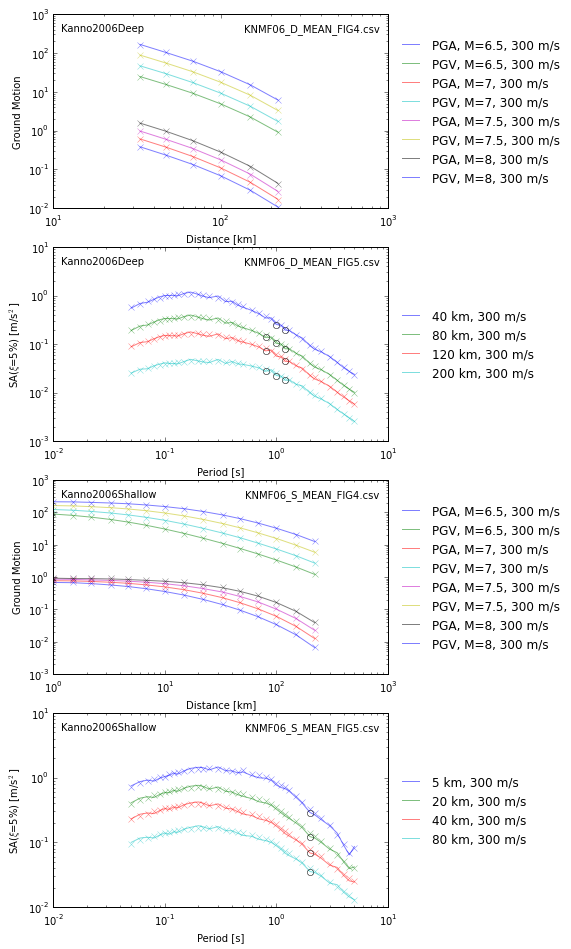

In [18]:
# run through unittests
threshhold = 0.10

means_files = sorted(glob.glob(os.path.join(os.path.split(means_files[0])[0],'*MEAN*')))
display(means_files)

fig, axes = plt.subplots(len(means_files), 1, figsize=(6,4*len(means_files)))

for ax, means_file in zip(axes, means_files):
    gmpe = [item for item, gmpe_short in zip(gmpes, gmpes_short) 
            if '_%s_' % gmpe_short in os.path.split(means_file)[1]][0]
    gmpe_name = gmpe.__class__.__name__
    ax.add_artist(AnchoredText(gmpe_name, 
                               loc=tb.LOC_CODE['upper left'], frameon=False))
    ax.add_artist(AnchoredText(os.path.split(means_file)[1], 
                               loc=tb.LOC_CODE['upper right'], frameon=False))

    df_ref = gt.df_massage(pd.read_csv(means_file))

    mags = np.sort(np.array(list(set(df_ref['rup_mag']))))
    rakes = 0
    distances = sorted(list(set(df_ref['dist_rrup'])))
    vs30s = np.sort(np.array(list(set(df_ref['site_vs30']))))
    sa_cols = np.array([tb.is_numeric(item) for item in df_ref.columns])
    imt_cols = np.array([gt.is_imt(item) for item in df_ref.columns])
    im_types = [gt.get_imt(item) for item in df_ref.columns[imt_cols]]

    df_new = gt.compute_gmpe(gmpe, mags, rakes, distances, vs30s, im_types)[0]
    df_new = df_new[df_ref.columns]

    if sum(sa_cols) > 2:  # x-axis will be spectral acceleration period
        for vs30 in vs30s:
            for dist in distances:
                trace_label = '%g km, %g m/s' % (dist, vs30)

                df_trace = df_ref[
                    (df_ref['dist_rrup'] == dist) & 
                    (df_ref['site_vs30'] == vs30)]
                if df_trace.size == 0:
                    continue
                ref = df_trace[df_ref.columns[sa_cols]]

                df_trace = df_new[
                    (df_new['dist_rrup'] == dist) & 
                    (df_new['site_vs30'] == vs30)]
                new = df_trace[df_ref.columns[sa_cols]]

                h = ax.loglog(new.columns.values, new.values.reshape((-1,)), 
                              label=trace_label, alpha=0.5)

                ax.loglog(ref.columns.values, ref.values.reshape((-1,)), 
                          linestyle='none', marker='x', 
                          color=h[0].get_color(), alpha=0.5)
                
                # circle points in error
                error = (np.abs(new.values/ref.values - 1) > threshhold).reshape((-1,))
                ax.loglog(new.iloc[0, error].index.values, new.iloc[0, error].values, 
                          linestyle='none', marker='o', color='black', markerfacecolor='none')
                
        ax.set_ylabel('SA($\\xi$=%g%%) [m/s$^2$]' % (im_types[0].damping))
        ax.set_xlabel('Period [s]')
        
    else:  # x-axis will be distance (could be magnitude)
        for vs30 in vs30s:
            for mag in mags:
                for im_type in im_types:
                    trace_label = '%s, M=%g, %g m/s' % (str(im_type), mag, vs30)

                    df_trace_ref = df_ref[
                        (df_ref['rup_mag'] == mag) & 
                        (df_ref['site_vs30'] == vs30)]
                    if df_trace_ref.size == 0:
                        continue

                    h = ax.loglog(df_trace_ref['dist_rrup'], df_trace_ref[str(im_type)], 
                                  label=trace_label, alpha=0.5)

                    df_trace_new = df_new[
                        (df_new['rup_mag'] == mag) & 
                        (df_new['site_vs30'] == vs30)]

                    ax.loglog(df_trace_new['dist_rrup'], df_trace_new[str(im_type)], 
                              linestyle='none', marker='x', 
                              color=h[0].get_color(), alpha=0.5)
                    
                    # circle points in error
                    error = (np.abs(df_trace_new[str(im_type)]/df_trace_ref[str(im_type)] - 1) > threshhold).reshape((-1,))
                    ax.loglog(df_trace_new.loc[error, 'dist_rrup'], df_trace_new.loc[error, str(im_type)], 
                              linestyle='none', marker='o', color='black', markerfacecolor='none')
            
        ax.set_ylabel('Ground Motion')
        ax.set_xlabel('Distance [km]')
        
    ax.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)
                
plt.savefig('Unit_Test_Summary.pdf', dpi=300, bbox_inches='tight')
plt.savefig('Unit_Test_Summary.png', dpi=300, bbox_inches='tight')